## METHODOLOGY

#### Supervised Part:

> 1. Load VGG16 model weights pre-trained on Imagenet. Call it `model_bottom`.    
     
> 2. Strip last 3 Dense Layers.   
    
> 3. Do a forward pass with `X_train` and `X_test` on `model_bottom`. Save outputs as `X_train_features` and `X_test_features`.

> 4. Reserve the first half of `(X_test_features, y_test)` for `(X_cv_features, y_cv)`.

> 5. Create a new model that accepts VGG16 bottleneck features as input. Call this `model_top`.

> 6. Train `model_top` on `X_train_features` with validation on `(X_cv_features, y_cv)`.

> 7.  Load best performing model weights and compute accuracy on `(X_test_features, y_test)`.

#### Now the Unsupervised Part:

> 8. Compute `y_unlabeled_predict` via forward pass with `X_unlabeled` on `model_top`.

> 9.  If max probability of `y_unlabeled_predict` exceeds `threshold = 0.9` on any class, append that example to an additional training data `X_train_add` with the class `y_train_add`.

> 10. Compute `X_train_add_features` via forward pass with `X_train_add` on `model_bottom`.

> 11. Concatenate `X_train_features` and `X_train_add_features` into `X_train_2_features`. Concatenate `y_train` and `y_train_add` into `y_train_2`.

> 12. Re-train `model_top` on `X_train_2_features` and `y_train_2` (N.B. use the STL-10 trained weights as initial weights). For cross-validation use same dataset `(X_cv_features, y_cv)`.

> 13. Load best performing model weights and compute accuracy on `(X_test_features, y_test)`.




In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13607804961581329941
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 167772160
locality {
  bus_id: 1
}
incarnation: 2619405364488050452
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
from stl10_input import *
import os, sys, tarfile, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator

params = {'legend.fontsize': 'x-large',
          'font.size'      : 10,
          'figure.figsize' : (17, 3),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)

DATA_PATH = './data/train_X.bin'
LABEL_PATH = './data/train_y.bin'

Using TensorFlow backend.


sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)


---

# Supervised Part

### Read in training and test STL-10 datasets

In [3]:
with open('data/train_X.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    raw = np.reshape(raw, (-1, 3, 96, 96))
    raw = np.transpose(raw, (0,3,2,1))
    X_train_raw = raw
    
with open('data/train_y.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    y_train = raw-1

with open('data/test_X.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    raw = np.reshape(raw, (-1, 3, 96, 96))
    raw = np.transpose(raw, (0,3,2,1))
    X_test_raw = raw

with open('data/test_y.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    y_test = raw-1
    
#---------------------------------------------------------
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 1000)
y_test  = to_categorical(y_test , num_classes = 1000)

### Resize the original `(96,96,3)` images to `(224,224,3)` 


In [4]:
start = time.time()
from PIL import Image

def resize_tensorimages(X_raw, interp_method=Image.BICUBIC):
    # VGG16 accepts input images of size (224, 224, 3)
    # Therefore, convert X_train_raw and X_test_raw to PIL.Image format, 
    # then resize the images from (96, 96, 3) to (224, 224, 3) 
    
    X_224 = np.zeros((X_raw.shape[0], 224, 224, 3))
    for i, _ in enumerate(X_raw):
        im = Image.fromarray(np.uint8(X_raw[i]))
        img = im.resize((224, 224), interp_method)
        X_224[i] = img
    
    return X_224

X_train = resize_tensorimages(X_train_raw)
X_test  = resize_tensorimages(X_test_raw)
    
del X_train_raw, X_test_raw
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print_runtime(start)

(5000, 224, 224, 3) (5000, 1000)
(8000, 224, 224, 3) (8000, 1000)
Runtime: 0 min 20 sec


---

# Obtain Bottleneck Features for VGG16
### 1.  Load VGG16 model weights pre-trained on Imagenet. Call it `model_bottom`.     


### 2.  Strip last 3 Dense Layers.   

In [5]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#---------------------------------------------------------

model_bottom = VGG16(include_top=False)

### 3. Do a forward pass with `X_train` and `X_test` on `model_bottom`.   Save outputs as `X_train_features` and `X_test_features`.

In [6]:
start = time.time()
#---------------------------------------------------------

# batch_size = 128

# X_train = preprocess_input(X_train) 
# X_test = preprocess_input(X_test) 
# d = model.predict(X_train[0:2])

# X_train_features = np.zeros((X_train.shape[0],*d.shape[1:]))

# for i in range(len(X_train)//batch_size):
#     idx = range(i*batch_size, (i+1)*batch_size)
#     print('Training set: %5.2f%%' % ((i+1)/(len(X_train)//batch_size)*100), end='\r')
#     X_train_features[idx] = model.predict(X_train[idx])    
# X_train_features[(i+1)*batch_size:] = model.predict(X_train[(i+1)*batch_size:])

# #---------------------------------------------------------
# print() 
# # Save `X_train_features` to `.npy` file, so you don't have to run this again.
# with open('data/X_train_features.npy', 'wb+') as f:
#     np.save(f, X_train_features)


### Load `X_train_features` from `.npy` file. 
with open('data/X_train_features.npy','rb') as f:
    X_train_features = np.load(f)     
#---------------------------------------------------------

### Compute `X_test_features` on pretrained `VGG16` model.
# X_test_features  = np.zeros((X_test.shape[0], *d.shape[1:]))
# for i in range(len(X_test)//batch_size):
#     idx = range(i*batch_size, (i+1)*batch_size)
#     print('Test set: %5.2f%%' % ((i+1)/(len(X_train)//batch_size)*100), end='\r')
#     X_test_features[idx] = model.predict(X_test[idx])
# X_test_features[(i+1)*batch_size:] = model.predict(X_test[(i+1)*batch_size:])

# print()
# # Save `X_test_features` to `.npy` file, so you don't have to run this again.
# with open('data/X_test_features.npy', 'wb+') as f:
#     np.save(f, X_test_features)


### Load `X_test_features` from `.npy` file.
with open('data/X_test_features.npy','rb') as f:
    X_test_features = np.load(f)
    
#---------------------------------------------------------
print_runtime(start)

Runtime: 0 min 0 sec


### 4. Split off the first half of `(X_test_features, y_test)` for `(X_cv_features, y_cv)`.

In [7]:
a = len(X_test_features) 
half = int(a/2) 

X_cv_features = X_test_features[:half] 
y_cv = y_test[:half] 

X_test_features = X_test_features[half:] 
y_test = y_test[half:] 

((X_test_features.shape, y_test.shape)), (X_cv_features.shape, y_cv.shape) 

(((4000, 7, 7, 512), (4000, 1000)), ((4000, 7, 7, 512), (4000, 1000)))

In [8]:
X_train_features.dtype, X_cv_features.dtype, X_test_features.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.

### 6. Train `model_top` on  `X_train_features` with validation on `(X_cv_features, y_cv)`.

In [9]:
model_top = get_model_top()
model_top, callback_inst = train_model(model_top, 
                                       X_train_features, y_train,
                                       X_cv_features, y_cv, 
                                       epochs=20,
                                       batch_size=128,
                                       wanna_plot=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              513000    
Total params: 513,000
Trainable params: 513,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....
Epoch 00000: val_loss improved from inf to 0.60450, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.60450 to 0.34581, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.34581 to 0.27818, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss improved from 0.27818 to 0.24262, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss improved from 0.24262 to 0.21987, saving model to saved_models/model.best.hdf5
Epoch 000

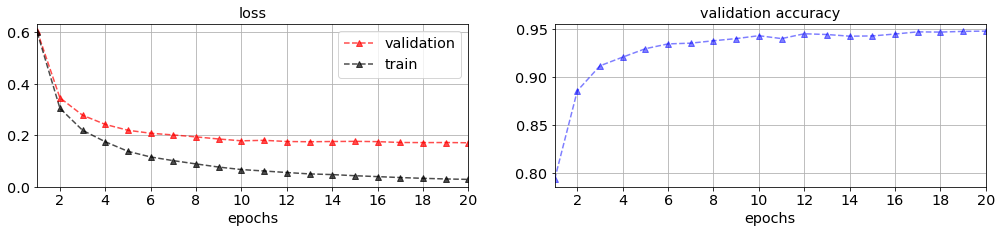

In [12]:
callback_inst.plotter()

### 7.  Compute test accuracy.

In [13]:
model_top.load_weights('saved_models/model.best.hdf5')

_loss, acc = model_top.evaluate(X_test_features, y_test, 
                                batch_size=128);
print('\nTest Accuracy = %.2f %%' % (acc*100))

3712/4000 [==========================>...] - ETA: 0s
Test Accuracy = 93.27 %


---

# Unsupervised Part

### Load unlabeled STL-10 data into `X_unlabeled_raw`.

In [14]:
## 2.8 GB !!! 
# The (224, 224, 3) tensor will not fit in memory.
# Build a generator
# with open('data/unlabeled_X.bin') as f:
#     raw = np.fromfile(f, dtype=np.uint8, count=-1)
#     raw = np.reshape(raw, (-1, 3, 96, 96))
#     raw = np.transpose(raw, (0,3,2,1))
#     X_unlabeled_raw = raw

# print(X_unlabeled_raw.shape)  
# print('X_unlabeled_raw.nbytes = %.2f MB' % (X_unlabeled_raw.nbytes/1e6)  )

### 8. Resize original `(96,96,3)` images to `(224,224,3)`––call them `X_unlabeled_224`.
### 9.  Compute `X_unlabeled_features ` via forward pass on `model_bottom`.
### 10.  Compute `y_unlabeled_predict` via forward pass of `X_unlabeled_features` on `model_top`.  
### 11. Save `X_unlabeled_features` and `y_unlabeled_predict` to corresponding `.npy` files.


In [15]:
# # NPY FILE MAKER

# start = time.time()

# # .....................................................................

# batch_size = 128
# sno = -1
# n_batches = len(X_unlabeled_raw)//batch_size

# X_unlabeled_raw = X_unlabeled_raw.astype('float32')
# X_unlabeled_features_repo = np.array([])

# for i in range(0, n_batches):
#     idx = range(i*batch_size, min((i+1)*batch_size, len(X_unlabeled_raw)))

#     # Resize raw image tensors.
#     X_unlabeled_224 = resize_tensorimages(X_unlabeled_raw[idx])
    
#     # Forward pass X_unlabeled_224 on model_bottom.
#     # (This is the time-consuming step.)
#     # X_unlabeled_features.shape = (128, 7, 7, 512)
#     X_unlabeled_features = model_bottom.predict(X_unlabeled_224, batch_size=batch_size) 
    
#     # Retrieve softmax probabilities on all classes.
#     # y_unlabeled_softmax.shape = (128, 1000)
#     y_unlabeled_softmax = model_top.predict(X_unlabeled_features) 
    
#     diff = time.time()-start
#     print('i = %d, n_batches = %d, Time: %d min %d sec  ' % (i, n_batches, diff//60, diff%60), end='\r')
    
#     if len(X_unlabeled_features_repo.shape) == 1:
#         X_unlabeled_features_repo = X_unlabeled_features
#         y_unlabeled_softmax_repo  = y_unlabeled_softmax
#     else:
#         X_unlabeled_features_repo = np.concatenate([X_unlabeled_features_repo, X_unlabeled_features])
#         y_unlabeled_softmax_repo  = np.concatenate([y_unlabeled_softmax_repo , y_unlabeled_softmax])
    
#     if X_unlabeled_features_repo.nbytes > 250*1e6:
#         sno = sno + 1
#         print()
#         npy_saver(X_unlabeled_features_repo, 'X_unlabeled_features', sno)
#         npy_saver(y_unlabeled_softmax_repo , 'y_unlabeled_softmax' , sno)
#         print('---------------------------------------------------------')
#         X_unlabeled_features_repo = np.array([])

# if len(X_unlabeled_features_repo) > 1:
#     sno = sno + 1
#     print()
#     npy_saver(X_unlabeled_features_repo, 'X_unlabeled_features', sno)
#     npy_saver(y_unlabeled_softmax_repo , 'y_unlabeled_softmax' , sno)

# del X_unlabeled_features_repo, y_unlabeled_softmax_repo, X_unlabeled_224
# print_runtime(start)
# print('\nDone!!')

### 11.  If max probability of `y_unlabeled_predict` exceeds `threshold = 0.9` on any class, append that example to an additional training data `X_train_add` with the class `y_train_add`.
##### Each `X_unlabeled_features_**.npy` is of length `2560` and size `257 MB`.

In [16]:
start = time.time()

threshold = .99
outX = []
outy = []

X_train_add_features = np.array([]) 
import glob
npys = glob.glob('data/*_softmax_*npy')
npys.sort(reverse=True)
highest_sno = int(npys[0].split('.npy')[0].split('_')[-1])

print('threshold = %.2f' % (threshold))
for sno in range(0, highest_sno):
    with open('data/%s_%02d.npy' % ('X_unlabeled_features', sno), 'rb') as fX,\
        open('data/%s_%02d.npy' % ('y_unlabeled_softmax', sno), 'rb') as fy:
        
        print('Reading in:', fX.name, ', ', fy.name , end='\r')
        X_unlabeled_features = np.load(fX) # shape (2560, 7, 7, 512)
        y_unlabeled_softmax  = np.load(fy) # (2560, 1000)

    # Find index of predicted class.
    # topclass_idx.shape = (2560,)
    topclass_idx = np.argmax(y_unlabeled_softmax, axis=1) 
    
    # prob: probability associated with topclass. shape = (2560,)
    prob = y_unlabeled_softmax[ range(y_unlabeled_softmax.shape[0]) , topclass_idx ]
    predict_idx = np.where(prob > threshold)[0]
    
    outX.append(X_unlabeled_features[predict_idx] )
    onehot = np.zeros((len(predict_idx) , 1000))
    onehot[range(len(predict_idx)), topclass_idx[predict_idx] ] = 1
    outy.append(onehot)
    
# ................................................................    
# with open('data/X_train_add_features.npy', 'wb+') as fX, \
#     open('data/y_train_add.npy', 'wb+') as fy:
#     np.save(fX, X_train_add_features)
#     np.save(fy, y_train_add)


X_train_add_features = np.concatenate(outX)
y_train_add = np.concatenate(outy)

print('\n', X_train_add_features.shape, y_train_add.shape)
print_runtime(start)

threshold = 0.99
Reading in: data/X_unlabeled_features_38.npy ,  data/y_unlabeled_softmax_38.npy
 (43235, 7, 7, 512) (43235, 1000)
Runtime: 0 min 7 sec


In [17]:
X_train_add_features.nbytes/1e6

4338.71872

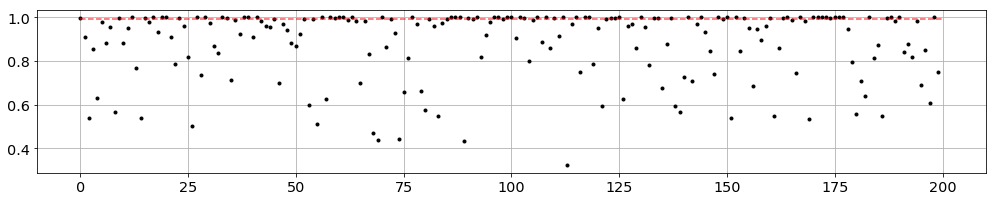

In [18]:
plt.plot(prob[:200],'k.');
plt.plot([0,200],[threshold]*2, 'r--', alpha = .65);

In [19]:
X_train_features_xpand = np.concatenate([X_train_features, X_train_add_features])
y_train_xpand = np.concatenate([y_train, y_train_add])
X_train_features_xpand.shape

(48235, 7, 7, 512)

### 12. Instantiate a Neural Network with same architecture.
### 13. Train on expanded dataset.

In [20]:
model_top = get_model_top()

model_top, callback_inst = train_model(model_top, 
                                       X_train_features_xpand, y_train_xpand,
                                       X_cv_features, y_cv, 
                                       epochs=7,
                                       batch_size=128,
                                       wanna_plot=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              513000    
Total params: 513,000
Trainable params: 513,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....
Epoch 00000: val_loss improved from inf to 0.21526, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.21526 to 0.18822, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 0.18822 to 0.18178, saving model to saved_models/model.best.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Runtime: 1 min 34 sec


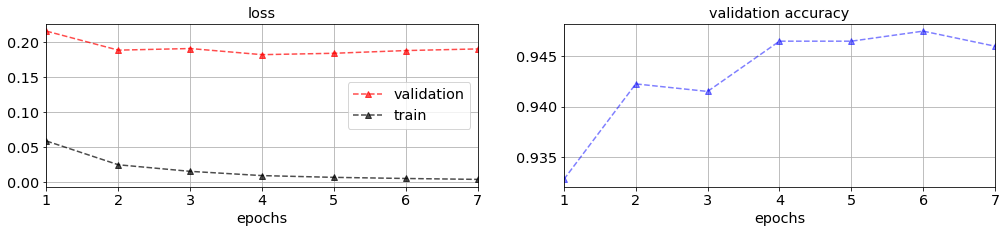

In [21]:
callback_inst.plotter()

In [22]:
model_top.load_weights('saved_models/model.best.hdf5')

_loss, acc = model_top.evaluate(X_test_features, y_test, 
                                batch_size=128);
print('\nthreshold = %.2f, Test Accuracy = %.2f %%' % (threshold, acc*100))

3712/4000 [==========================>...] - ETA: 0s
threshold = 0.99, Test Accuracy = 93.53 %


In [30]:
cnames, fidx = get_cnames_fidx()